In [52]:
# install.packages('ggraph')
# install.packages('igraph')
# install.packages('hrbrthemes')

In [310]:
library('data.table')
library('dplyr')
library('tidyr')
library('ggplot2')
library('scales')
library('igraph')
library('ggraph')
library('viridis')
library('hrbrthemes')
library('gridExtra')


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [54]:
titles <- fread("title_ratings", quote="", na.strings = "\\N")
aka <- fread("aka_filtered", quote = "", na.strings = "\\N")
crew <- fread("crew_filtered", na.strings = "\\N")
principals <- fread("principals_filtered", quote="", na.strings = "\\N")
ep_series <- fread("episodes_filtered", na.strings = "\\N")
names <-fread("names_filtered_new", na.strings = "\\N")

In [ ]:
# titles and their ratings
head(titles, 3)
# the names of the titles in different languages, probably not relevant
head(aka, 3)
# list of writers and directors for each movie
head(crew, 3)
# list of roles of an actor in the given movie
head(principals, 3)
# table tying episodes to its tvSeries
head(ep_series, 3)
# names of the actors with the titles they starred in
head(names, 3)

In [56]:
head(ep_series, 3)
count(ep_series)

tconst,parentTconst,seasonNumber,episodeNumber
<chr>,<chr>,<int>,<int>
tt0114532,tt0874686,1,2
tt0124961,tt0159876,49,15
tt0130097,tt0273026,NA,NA


n
<int>
459089


## Further filtering

### Series episodes split

In [63]:
series <- titles %>% filter(titleType != 'tvEpisode')
episodes <- titles %>% filter(titleType == 'tvEpisode')
count(series)
count(episodes)

n
<int>
77090


n
<int>
459147


### Filter tvSeries under 1000 reviews and their related elements

In [64]:
series <- series %>% filter(numVotes >= 1000)

In [65]:
ep_series <- ep_series %>% filter(parentTconst %in% series$tconst)

In [66]:
episodes <- episodes %>% filter(tconst %in% ep_series$tconst)

In [67]:
principals <- principals %>% filter(tconst %in% series$tconst | tconst %in% episodes$tconst)
names_filtered <- names %>% filter(nconst %in% principals$nconst)
aka_filtered <- aka %>% filter(titleId %in% series$tconst | titleId %in% episodes$tconst)
crew_filtered <- crew %>% filter(tconst %in% series$tconst | tconst %in% episodes$tconst)

Add number of seasons to the tv series

In [68]:
num_seasons <- ep_series %>% filter(!is.na(seasonNumber)) %>% group_by(parentTconst) %>% summarize(seasons = max(seasonNumber))

In [69]:
series <- merge(x = series, y = num_seasons, by.x = 'tconst', by.y = 'parentTconst', all.x = TRUE, all.y = FALSE)

### Data transformations

In [70]:
# series and episodes, - split genres, type -> factor
series$titleType = as.factor(series$titleType)
series <- series %>% mutate(genres = strsplit(genres, split=','))
episodes$titleType = as.factor(episodes$titleType)
episodes <- episodes %>% mutate(genres = strsplit(genres, split=','))
head(episodes)

tconst,titleType,primaryTitle,originalTitle,isAdult,runtimeMinutes,genres,year,averageRating,numVotes
<chr>,<fct>,<chr>,<chr>,<lgl>,<int>,<list>,<int>,<dbl>,<int>
tt0182919,tvEpisode,Murder with Too Many Notes,Murder with Too Many Notes,FALSE,98,"Crime , Drama , Mystery",2000,6.7,1666
tt0187660,tvEpisode,The Octopus 10,La piovra 10,FALSE,102,"Crime , Drama , Mystery",2001,7.3,295
tt0199398,tvEpisode,The Terracotta Dog,Il cane di terracotta,FALSE,102,"Crime , Drama , Mystery",2000,7.6,281
tt0199536,tvEpisode,The Shape of Water,La forma dell'acqua,FALSE,112,"Crime , Drama , Mystery",2000,7.5,386
tt0221289,tvEpisode,Pilot,Pilot,FALSE,120,"Action, Comedy, Sci-Fi",2000,7.6,468
tt0235326,tvEpisode,Pilot,Pilot,FALSE,87,"Action , Drama , Mystery",2000,7.3,2427


In [71]:
# crew - split directors and writers
crew <- crew %>% mutate(directors = strsplit(directors, split = ','), writers = strsplit(writers, split = ','))
head(crew, 3)

tconst,directors,writers
<chr>,<list>,<list>
tt0043224,"nm0477438, nm0054846, nm1096821, nm0705228, nm0120437, nm0076971, nm0387695, nm0232902, nm1097266, nm1637827","nm0804026, nm0639495, nm0680226, nm0777442, nm0706417, nm0722289, nm1640023, nm0338876, nm0326239, nm0777129, nm0414633, nm0288997, nm1520544, nm0799745, nm0615080, nm0293159, nm0771627, nm0918826, nm0410536, nm2204703, nm0397170, nm0917200, nm0594174, nm0917026, nm0566588, nm0288816, nm3123274, nm0051332, nm2964448, nm0237341, nm0329085, nm1034110, nm3110698, nm0516015, nm0057677, nm0578441, nm0814068, nm0081748, nm0606806, nm0639787, nm0432188, nm0498586, nm0743232, nm2198070, nm0743259, nm0777202, nm0380890, nm2915847, nm0377958, nm1290769, nm7410201, nm0545131, nm0655462, nm3201019, nm0001992, nm0399849, nm0000036"
tt0044265,"nm0004098, nm0179413, nm1597578, nm1335675, nm0915727, nm0581589, nm0568114, nm0213789, nm0281224, nm0332752, nm0884037, nm0297489, nm0109586, nm0331135, nm1513459, nm0778479, nm0224683, nm0159012, nm0100841, nm0250864, nm2681961, nm1273119, nm0923396, nm0369858, nm2036776, nm1334802, nm1603516, nm1314913, nm1343326, nm0925870, nm0834419, nm2552851, nm3174789, nm0963061, nm0571983, nm0322900","nm2419908 , nm1141830 , nm2251709 , nm2078312 , nm1003809 , nm0325029 , nm1014203 , nm1014177 , nm0492953 , nm1012482 , nm1010971 , nm0519133 , nm0174585 , nm0429390 , nm2429218 , nm2654235 , nm1221904 , nm0068550 , nm1159577 , nm0909529 , nm3049540 , nm0255819 , nm0260547 , nm0113780 , nm0628248 , nm0717622 , nm0989904 , nm1142664 , nm0191612 , nm1051829 , nm2727176 , nm4972117 , nm0997483 , nm0110828 , nm1105215 , nm3079954 , nm1779986 , nm2085815 , nm0693044 , nm0106187 , nm0322325 , nm0833510 , nm0807006 , nm0542021 , nm3454108 , nm0566699 , nm2721275 , nm4237316 , nm0291507 , nm0027442 , nm1267575 , nm1011786 , nm0750422 , nm1014193 , nm0820121 , nm1011976 , nm1000132 , nm1007597 , nm0792404 , nm1049086 , nm0996693 , nm1088908 , nm0229890 , nm0229908 , nm0913330 , nm0758444 , nm3059609 , nm0782462 , nm0746169 , nm0925335 , nm0925388 , nm0501148 , nm2040174 , nm0711626 , nm1480454 , nm0421246 , nm0846520 , nm0922948 , nm2591020 , nm0925872 , nm1012917 , nm9109568 , nm0617002 , nm0682274 , nm3566933 , nm0723559 , nm1779949 , nm0658855 , nm0880986 , nm1276101 , nm1299367 , nm0434560 , nm0115032 , nm1011004 , nm0358462 , nm2272293 , nm0906799 , nm0479525 , nm0997301 , nm3579833 , nm0534951 , nm1802728 , nm0680460 , nm2654307 , nm0866801 , nm2660138 , nm1669530 , nm0040612 , nm0481805 , nm1106086 , nm0899533 , nm2077775 , nm2220634 , nm1049067 , nm2006443 , nm0812026 , nm0111576 , nm0698989 , nm0019706 , nm0111577 , nm0122417 , nm0202681 , nm0238898 , nm0505615 , nm0754581 , nm0789737 , nm0991335 , nm0162914 , nm1301702 , nm3059996 , nm0726721 , nm1014206 , nm2233247 , nm0235902 , nm10360337, nm1672253 , nm1440687 , nm1400899 , nm5846217 , nm0817957 , nm2076865 , nm9551033 , nm3930118 , nm0068589 , nm0633202 , nm0881501 , nm0813960 , nm0989955 , nm0031021 , nm0097597 , nm0112601 , nm0148223 , nm0313072 , nm0368575 , nm0513851 , nm0564474"
tt0048845,"nm0332752, nm0824738, nm0100841, nm0179413, nm0251732, nm0887790, nm4029369, nm0245698, nm0777413, nm0114113, nm0157553, nm0384316, nm0906004, nm0041715, nm0219989, nm0242409, nm1681063, nm1212523, nm0856388, nm0004098, nm0594204, nm0046490, nm1408290, nm0446060, nm0483582, nm0357800, nm0639479, nm0581589, nm2483215, nm0213789, nm0017875, nm0802986, nm0295925, nm1656173, nm0884037, nm1032520, nm0591523, nm1010949, nm0923396, nm0672625, nm0867723, nm1603516, nm0109586, nm0571983, nm0677210, nm0139400, nm0656440, nm0125226, nm0672627, nm0641266, nm0723593, nm0963061","nm0664799 , nm1923276 , nm1007597 , nm2419908 , nm1010949 , nm3049540 , nm1779949 , nm1779986 , nm1049066 , nm0680460 , nm0633202 , nm0790760 , nm1014174 , nm1299367 , nm1014216 , nm0045741 , nm1014167 , nm1011004 , nm0481805 , nm0909529 , nm1014175 , nm0106187 , nm0787317 , nm0655491 , nm1780023 , nm1011440 , nm0792404 , nm1010971 , nm11418

In [72]:
# principals - delete brackets from characters and split, catogry -> factor
principals$category <- as.factor(principals$category)
principals$characters <- gsub("\\]", '', principals$characters)
principals$characters <- gsub("\\[", '', principals$characters)
principals$characters <- gsub('"', '', principals$characters)
principals$characters <- gsub('"', '', principals$characters)
principals <- principals %>% mutate(characters = strsplit(characters, split = ','))
head(principals, 3)

tconst,ordering,nconst,category,job,characters
<chr>,<int>,<chr>,<fct>,<chr>,<list>
tt0043224,10,nm0461246,self,NA,"Self - Commercials , Commercials , Blonde Nurse-Hospital Sketch"
tt0043224,1,nm0804026,self,NA,"Self - Host , Clem Kadiddlehopper , Freddie the Freeloader"
tt0043224,2,nm2582914,self,NA,"Themselves, Orchestra , Singers"


In [73]:
# ep_series - season and ep number -> int
ep_series$seasonNumber <- as.integer(ep_series$seasonNumber)
ep_series$episodeNumber <- as.integer(ep_series$episodeNumber)
head(ep_series, 3)

tconst,parentTconst,seasonNumber,episodeNumber
<chr>,<chr>,<int>,<int>
tt0182919,tt1466074,13,4
tt0187660,tt0086779,10,1
tt0199398,tt0920489,2,2


In [74]:
# names - split proffesion and titles
names <- names %>% mutate(primaryProfession = strsplit(primaryProfession, split = ','))
head(names, 3)

nconst,primaryName,birthYear,deathYear,primaryProfession,ratings_total,avg_rating,n
<chr>,<chr>,<int>,<int>,<list>,<int>,<dbl>,<int>
nm1217514,Rodrigo Ordoñez,1972,NA,"writer , director , assistant_director",358,6.375000,4
nm1217515,Suze Orman,1951,NA,"producer, actress",528315,7.925000,4
nm1217519,Yaky Ortega,NA,NA,"director , miscellaneous",468,7.033333,4


In [75]:
# free up memory after transformations
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,8147751,435.2,14349745,766.4,14349745,766.4
Vcells,97608006,744.7,178628355,1362.9,178628354,1362.9


## Project

### People + aggregate data of the series they played in

This few cells probably useless, keeping them just to make sure

In [76]:
title_person = merge(principals, series, by = "tconst", all=FALSE)
head(title_person, 10)

tconst,ordering,nconst,category,job,characters,titleType,primaryTitle,originalTitle,isAdult,runtimeMinutes,genres,year,averageRating,numVotes,seasons
<chr>,<int>,<chr>,<fct>,<chr>,<list>,<fct>,<chr>,<chr>,<lgl>,<int>,<list>,<int>,<dbl>,<int>,<int>
tt0043224,10,nm0461246,self,NA,"Self - Commercials , Commercials , Blonde Nurse-Hospital Sketch",tvSeries,The Red Skelton Hour,The Red Skelton Show,FALSE,60,Comedy,2016,8.1,1285,NA
tt0043224,1,nm0804026,self,NA,"Self - Host , Clem Kadiddlehopper , Freddie the Freeloader",tvSeries,The Red Skelton Hour,The Red Skelton Show,FALSE,60,Comedy,2016,8.1,1285,NA
tt0043224,2,nm2582914,self,NA,"Themselves, Orchestra , Singers",tvSeries,The Red Skelton Hour,The Red Skelton Show,FALSE,60,Comedy,2016,8.1,1285,NA
tt0043224,3,nm0319497,actor,NA,"Announcer , Self - Announcer , Baseball Broadcaster",tvSeries,The Red Skelton Hour,The Red Skelton Show,FALSE,60,Comedy,2016,8.1,1285,NA
tt0043224,4,nm2785822,self,NA,"Themselves , Can Can Dancers, Harem Dancers",tvSeries,The Red Skelton Hour,The Red Skelton Show,FALSE,60,Comedy,2016,8.1,1285,NA
tt0043224,5,nm0545131,writer,created by,NA,tvSeries,The Red Skelton Hour,The Red Skelton Show,FALSE,60,Comedy,2016,8.1,1285,NA
tt0043224,6,nm0038066,actor,NA,"Paw Kadiddlehopper, Pa Kadiddlehopper , Muggsy",tvSeries,The Red Skelton Hour,The Red Skelton Show,FALSE,60,Comedy,2016,8.1,1285,NA
tt0043224,7,nm3124732,self,NA,"Themselves, Selves , Singers",tvSeries,The Red Skelton Hour,The Red Skelton Show,FALSE,60,Comedy,2016,8.1,1285,NA
tt0043224,8,nm0483617,actor,NA,"Announcer , Self - Announcer",tvSeries,The Red Skelton Hour,The Red Skelton Show,FALSE,60,Comedy,2016,8.1,1285,NA


In [77]:
name_ratings <- title_person %>% group_by(nconst) %>% summarise(
    meanRating = mean(averageRating), averageVotes = mean(numVotes), weightedRating = sum(averageRating *  numVotes), sumVotes=sum(numVotes), ) %>%
    transform(weightedRating = weightedRating / sumVotes)

In [78]:
actor_rating <- title_person %>% filter(category == 'actor') %>% group_by(nconst) %>% summarise(
    meanRating = mean(averageRating), averageVotes = mean(numVotes), weightedRating = sum(averageRating *  numVotes), sumVotes=sum(numVotes)) %>%
    transform(weightedRating = weightedRating / sumVotes)
head(actor_rating, 3)

,nconst,meanRating,averageVotes,weightedRating,sumVotes
,<chr>,<dbl>,<dbl>,<dbl>,<int>
1,nm0000056,7.20,5874.0,7.200000,5874
2,nm0000092,8.55,28228.5,8.788372,56457
3,nm0000093,7.30,2305.0,7.300000,2305


### Quality of the cast and crew across genres

In [79]:
names_tmp <- names %>% mutate(ratings_total = (ratings_total / n))

In [80]:
names_tmp$ratings_total <- scales::rescale(names_tmp$ratings_total, to=c(0,1))
names_tmp$avg_rating <- scales::rescale(names_tmp$avg_rating, to=c(0,1))

**Success** - min max scaled and combined values of ratings and num of reviews of movies a person is known for

In [218]:
names_tmp <- names_tmp %>% mutate(success = (ratings_total + avg_rating) / 2 * 10)

In [267]:
comedies <- series %>% mutate(new_col = lapply(genres, function (x) 'Comedy' %in% x)) %>% filter(new_col == TRUE) %>% select(-new_col)
comedies$averageRating <- scales::rescale(comedies$averageRating, to = c(0,1))
comedies$numVotes <- scales::rescale(comedies$numVotes, to = c(0,1))
comedies$seasons <- scales::rescale(comedies$seasons, to = c(0,1))
comedies <- comedies %>% mutate(com_success = (averageRating + numVotes + seasons) / 3 * 10)

In [271]:
comedies_actor <- merge(comedies, principals, by.x = 'tconst', by.y = 'tconst', x.all = FALSE, y.all = FALSE)
comedies_actor <- comedies_actor %>% filter(category == 'actor')
comedies_actor <- merge(comedies_actor, names_tmp, by.x = 'nconst', by.y = 'nconst', all.x = FALSE, all.y = FALSE)
comedies_actor <- comedies_actor %>% filter(!is.na(com_success)) %>% group_by(tconst, com_success) %>% summarize(crew_success = mean(success))  %>% mutate(type = 'actors')

In [286]:
crew_direc <- fread("crew_filtered", na.strings = "\\N")
crew_direc <- crew_direc %>% mutate(writers = strsplit(writers, split = ','))
crew_direc <- separate_rows(crew_direc, directors)
crew_direc <- crew_direc %>% select(-writers)

In [287]:
comedies_direc <- merge(comedies, crew_direc, by.x = 'tconst', by.y = 'tconst', x.all = FALSE, y.all = FALSE)
comedies_direc <- merge(comedies_direc, names_tmp, by.x = 'directors', by.y = 'nconst', all.x = FALSE, all.y = FALSE)
comedies_direc <- comedies_direc %>% group_by(tconst, com_success) %>% summarize(crew_success = mean(success)) %>% filter(!is.na(com_success)) %>% mutate(type = 'directors')

`summarise()` has grouped output by 'tconst'. You can override using the `.groups` argument.


In [275]:
crew_write <- fread("crew_filtered", na.strings = "\\N")
crew_write <- crew_write %>% mutate(directors = strsplit(writers, split = ','))
crew_write <- separate_rows(crew_write, writers)
crew_write <- crew_write %>% select(-directors)

In [276]:
comedies_write <- merge(comedies, crew_write, by.x = 'tconst', by.y = 'tconst', x.all = FALSE, y.all = FALSE)
comedies_write <- merge(comedies_write, names_tmp, by.x = 'writers', by.y = 'nconst', all.x = FALSE, all.y = FALSE)
comedies_write <- comedies_write %>% group_by(tconst, com_success) %>% summarize(crew_success = mean(success)) %>% filter(!is.na(com_success)) %>% mutate(type = 'writers')

`summarise()` has grouped output by 'tconst'. You can override using the `.groups` argument.


In [278]:
full <- rbind(comedies_direc, comedies_write)
full <- rbind(full, comedies_actor)

In [ ]:
ggplot(full, aes(x=crew_success, y=com_success, color = type, shape = type)) + 
    geom_point(size=1) +
    geom_smooth(method='lm') +
    theme_ipsum()

In [302]:
names_tmp <- names %>% mutate(ratings_total = (ratings_total / n))
names_tmp$ratings_total <- scales::rescale(names_tmp$ratings_total, to=c(0,1))
names_tmp$avg_rating <- scales::rescale(names_tmp$avg_rating, to=c(0,1))
names_tmp <- names_tmp %>% mutate(success = (ratings_total + avg_rating) / 2 * 10)

In [303]:
comedies <- series %>% mutate(new_col = lapply(genres, function (x) 'Comedy' %in% x)) %>% filter(new_col == TRUE) %>% select(-new_col)


In [304]:
crew_write <- fread("crew_filtered", na.strings = "\\N")
crew_write <- crew_write %>% mutate(directors = strsplit(writers, split = ','))
crew_write <- separate_rows(crew_write, writers)
crew_write <- crew_write %>% select(-directors)

In [305]:
crew_direc <- fread("crew_filtered", na.strings = "\\N")
crew_direc <- crew_direc %>% mutate(writers = strsplit(writers, split = ','))
crew_direc <- separate_rows(crew_direc, directors)
crew_direc <- crew_direc %>% select(-writers)

In [330]:
create_genre_plot <- function (genre) {
    comedies <- series %>% mutate(new_col = lapply(genres, function (x) genre %in% x)) %>% filter(new_col == TRUE) %>% select(-new_col)
    comedies$averageRating <- scales::rescale(comedies$averageRating, to = c(0,1))
    comedies$numVotes <- scales::rescale(comedies$numVotes, to = c(0,1))
    comedies$seasons <- scales::rescale(comedies$seasons, to = c(0,1))
    comedies <- comedies %>% mutate(com_success = (averageRating + numVotes + seasons) / 3 * 10)
                                                   
    comedies_actor <- merge(comedies, principals, by.x = 'tconst', by.y = 'tconst', x.all = FALSE, y.all = FALSE)
    comedies_actor <- comedies_actor %>% filter(category == 'actor')
    comedies_actor <- merge(comedies_actor, names_tmp, by.x = 'nconst', by.y = 'nconst', all.x = FALSE, all.y = FALSE)
    comedies_actor <- comedies_actor %>% filter(!is.na(com_success)) %>% group_by(tconst, com_success) %>% summarize(crew_success = mean(success))  %>% mutate(type = 'actors')

    comedies_direc <- merge(comedies, crew_direc, by.x = 'tconst', by.y = 'tconst', x.all = FALSE, y.all = FALSE)
    comedies_direc <- merge(comedies_direc, names_tmp, by.x = 'directors', by.y = 'nconst', all.x = FALSE, all.y = FALSE)
    comedies_direc <- comedies_direc %>% group_by(tconst, com_success) %>% summarize(crew_success = mean(success)) %>% filter(!is.na(com_success)) %>% mutate(type = 'directors')
                                                   
    comedies_write <- merge(comedies, crew_write, by.x = 'tconst', by.y = 'tconst', x.all = FALSE, y.all = FALSE)
    comedies_write <- merge(comedies_write, names_tmp, by.x = 'writers', by.y = 'nconst', all.x = FALSE, all.y = FALSE)
    comedies_write <- comedies_write %>% group_by(tconst, com_success) %>% summarize(crew_success = mean(success)) %>% filter(!is.na(com_success)) %>% mutate(type = 'writers')
                                                   
    full <- rbind(comedies_direc, comedies_write)
    full <- rbind(full, comedies_actor)
    plt <- ggplot(full, aes(x=crew_success, y=com_success, color = type, shape = type)) + 
            ggtitle(genre) +
            geom_point(size=1) +
            geom_smooth(method='lm') +
            theme(legend.position="none") +
            theme_ipsum()
    return(plt)
}

In [331]:
options(dplyr.summarise.inform = FALSE)

In [332]:
chosen_genres <- c('Drama', 'Comedy', 'Crime', 'Action', 'Animation', 'Adventure', 'Mystery', 'Romance', 'Documentary')
plots <- lapply(chosen_genres, create_genre_plot)

In [333]:
options(repr.plot.width=12, repr.plot.height=8, repr.plot.res = 250)

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 122 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 122 rows containing missing values (`geom_point()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 127 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 127 rows containing missing values (`geom_point()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 45 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 45 rows containing missing values (`geom_point()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 49 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 49 rows containing missing values (`geom_point()`).”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 52 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 52 rows containing missing values (`geo

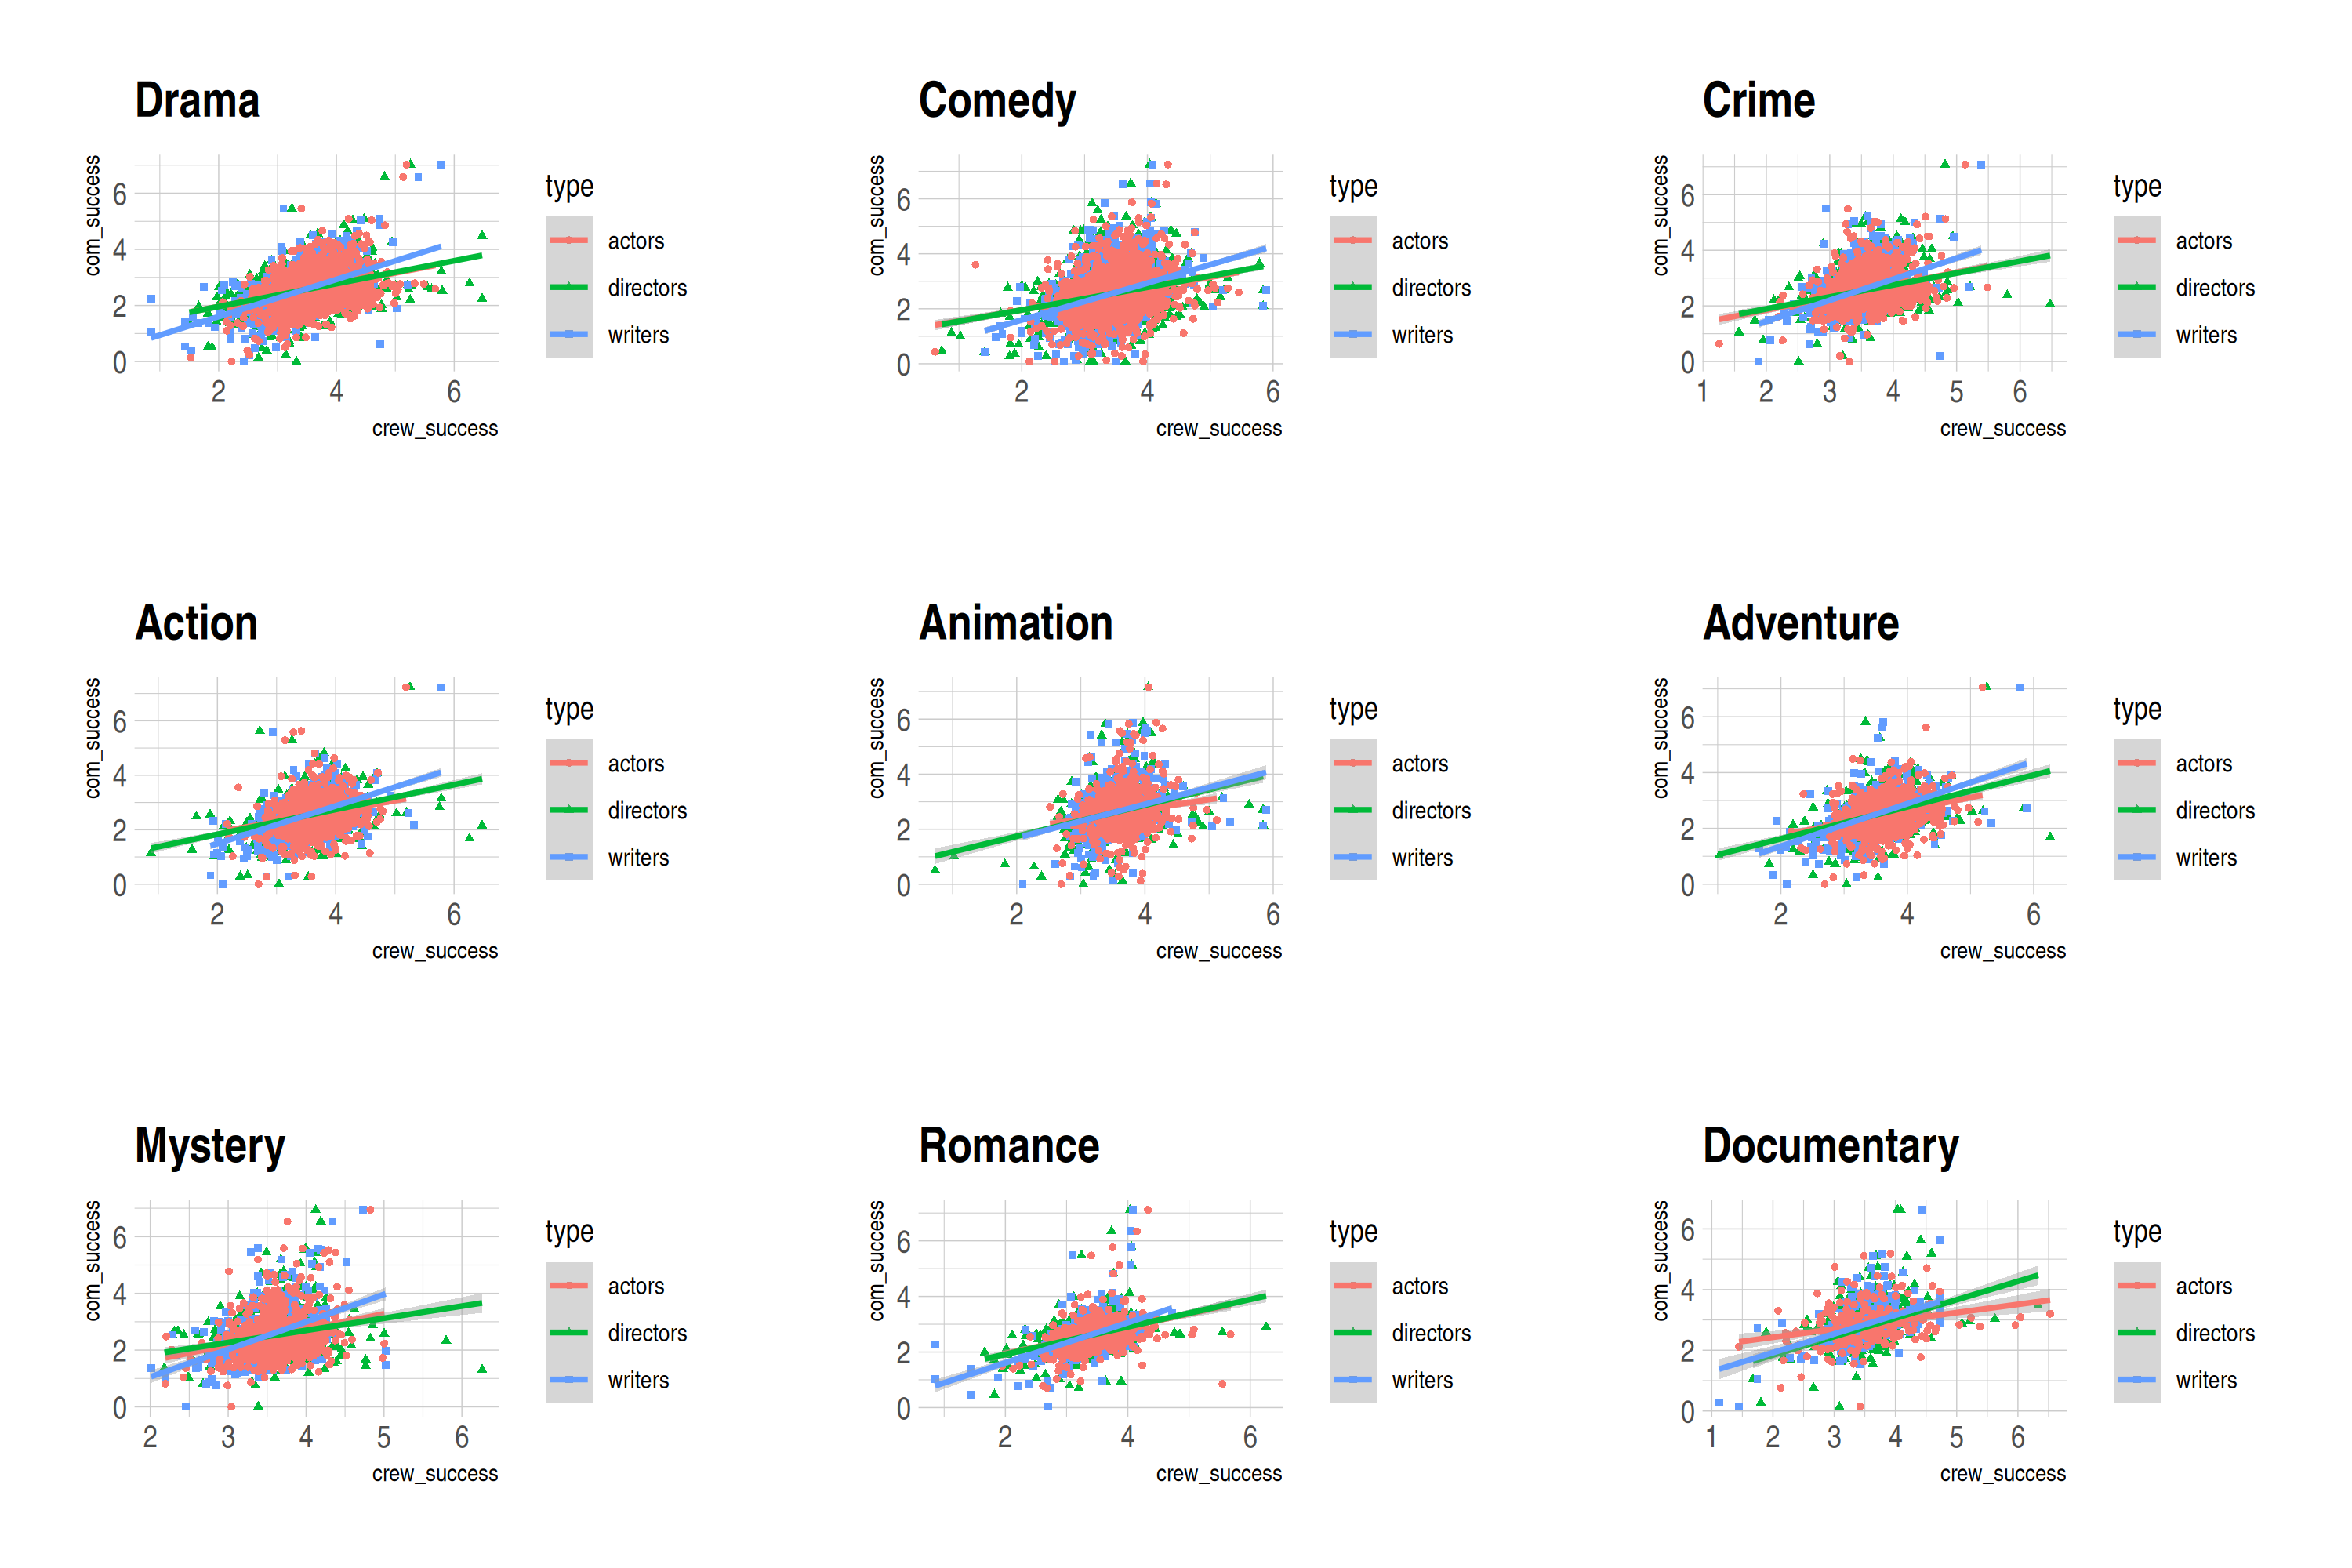

In [334]:
grid.arrange(grobs = plots, ncol = 3)

### Heatmap of categories together

In [300]:
genres_list <- as.data.frame(table(unlist(series$genres)))
genres_list <- genres_list  %>% arrange(by = -Freq) %>% filter(Freq > 300)
genres_list <- genres_list$Var1

[1] Drama       Comedy      Crime       Action      Animation   Adventure  
[7] Mystery     Romance     Documentary
26 Levels: Action Adventure Animation Biography Comedy Crime ... Western

In [88]:
genres_list <- genres_list[order(genres_list)]

In [89]:
series_temp <- series

In [90]:
series_temp$genres <- lapply(series_temp$genres, function (x) x[x %in% genres_list])

In [91]:
heat_df <- data.frame(x = character(), y = character(), reviews_avg = double(), rating_avg = double(), amount = integer(), seasons = integer())

In [92]:
series_temp$new_col <- lapply(series_temp$genres, function (x) 'Animation' %in% x & 'Comedy' %in% x)
series_temp$seasons <- as.numeric(series_temp$seasons)
a <- series_temp[series_temp$new_col == TRUE] %>% head() %>% select(seasons) %>% filter(!is.na(seasons))
mean(unlist(select(a, seasons)), na.rm = TRUE)

[1] 10.5

In [93]:
for (k in 1:length(genres_list)) {
    for (l in k:length(genres_list)) {
        i = genres_list[k]
        j = genres_list[l]
        series_temp$new_col <- lapply(series_temp$genres, function (x) i %in% x & j %in% x)
        tmp <- series_temp %>% filter(new_col == TRUE)
        num <- count(tmp)
        tmp <- tmp %>% summarise(suma = mean(numVotes), rating = mean(averageRating), seasons = trunc(mean(unlist(seasons), na.rm = TRUE)))
        if (i == 'Crime' & j == 'Family') {
            tmp[[3]] <- 0
        }
        heat_df <- heat_df %>% add_row(x = i, y = j, reviews_avg = tmp[[1]], rating_avg = tmp[[2]], amount = num[[1]], seasons = tmp[[3]])
    }
}

In [94]:
heat_df

x,y,reviews_avg,rating_avg,amount,seasons
<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>
Action,Action,22727.534,7.188538,1300,2
Action,Adventure,27297.291,7.143506,616,2
Action,Animation,12166.275,7.305348,561,2
Action,Comedy,17716.792,7.216337,202,2
Action,Crime,28722.724,7.192996,257,2
Action,Documentary,2589.250,7.575000,4,3
Action,Drama,33770.417,7.207466,509,2
Action,Family,2882.667,6.193333,15,1
Action,Fantasy,28534.545,7.172727,77,1


In [95]:
options(repr.plot.width=8, repr.plot.height=7, repr.plot.res = 250)

**Categories together average num of reviews and average rating**
* The success of historical thriller caused by Chernobyl and not many other things in the genre
* It is on the dataset of tvSeries with more than 1k reviews but I tried on the unfiltered one and the results were almost identical

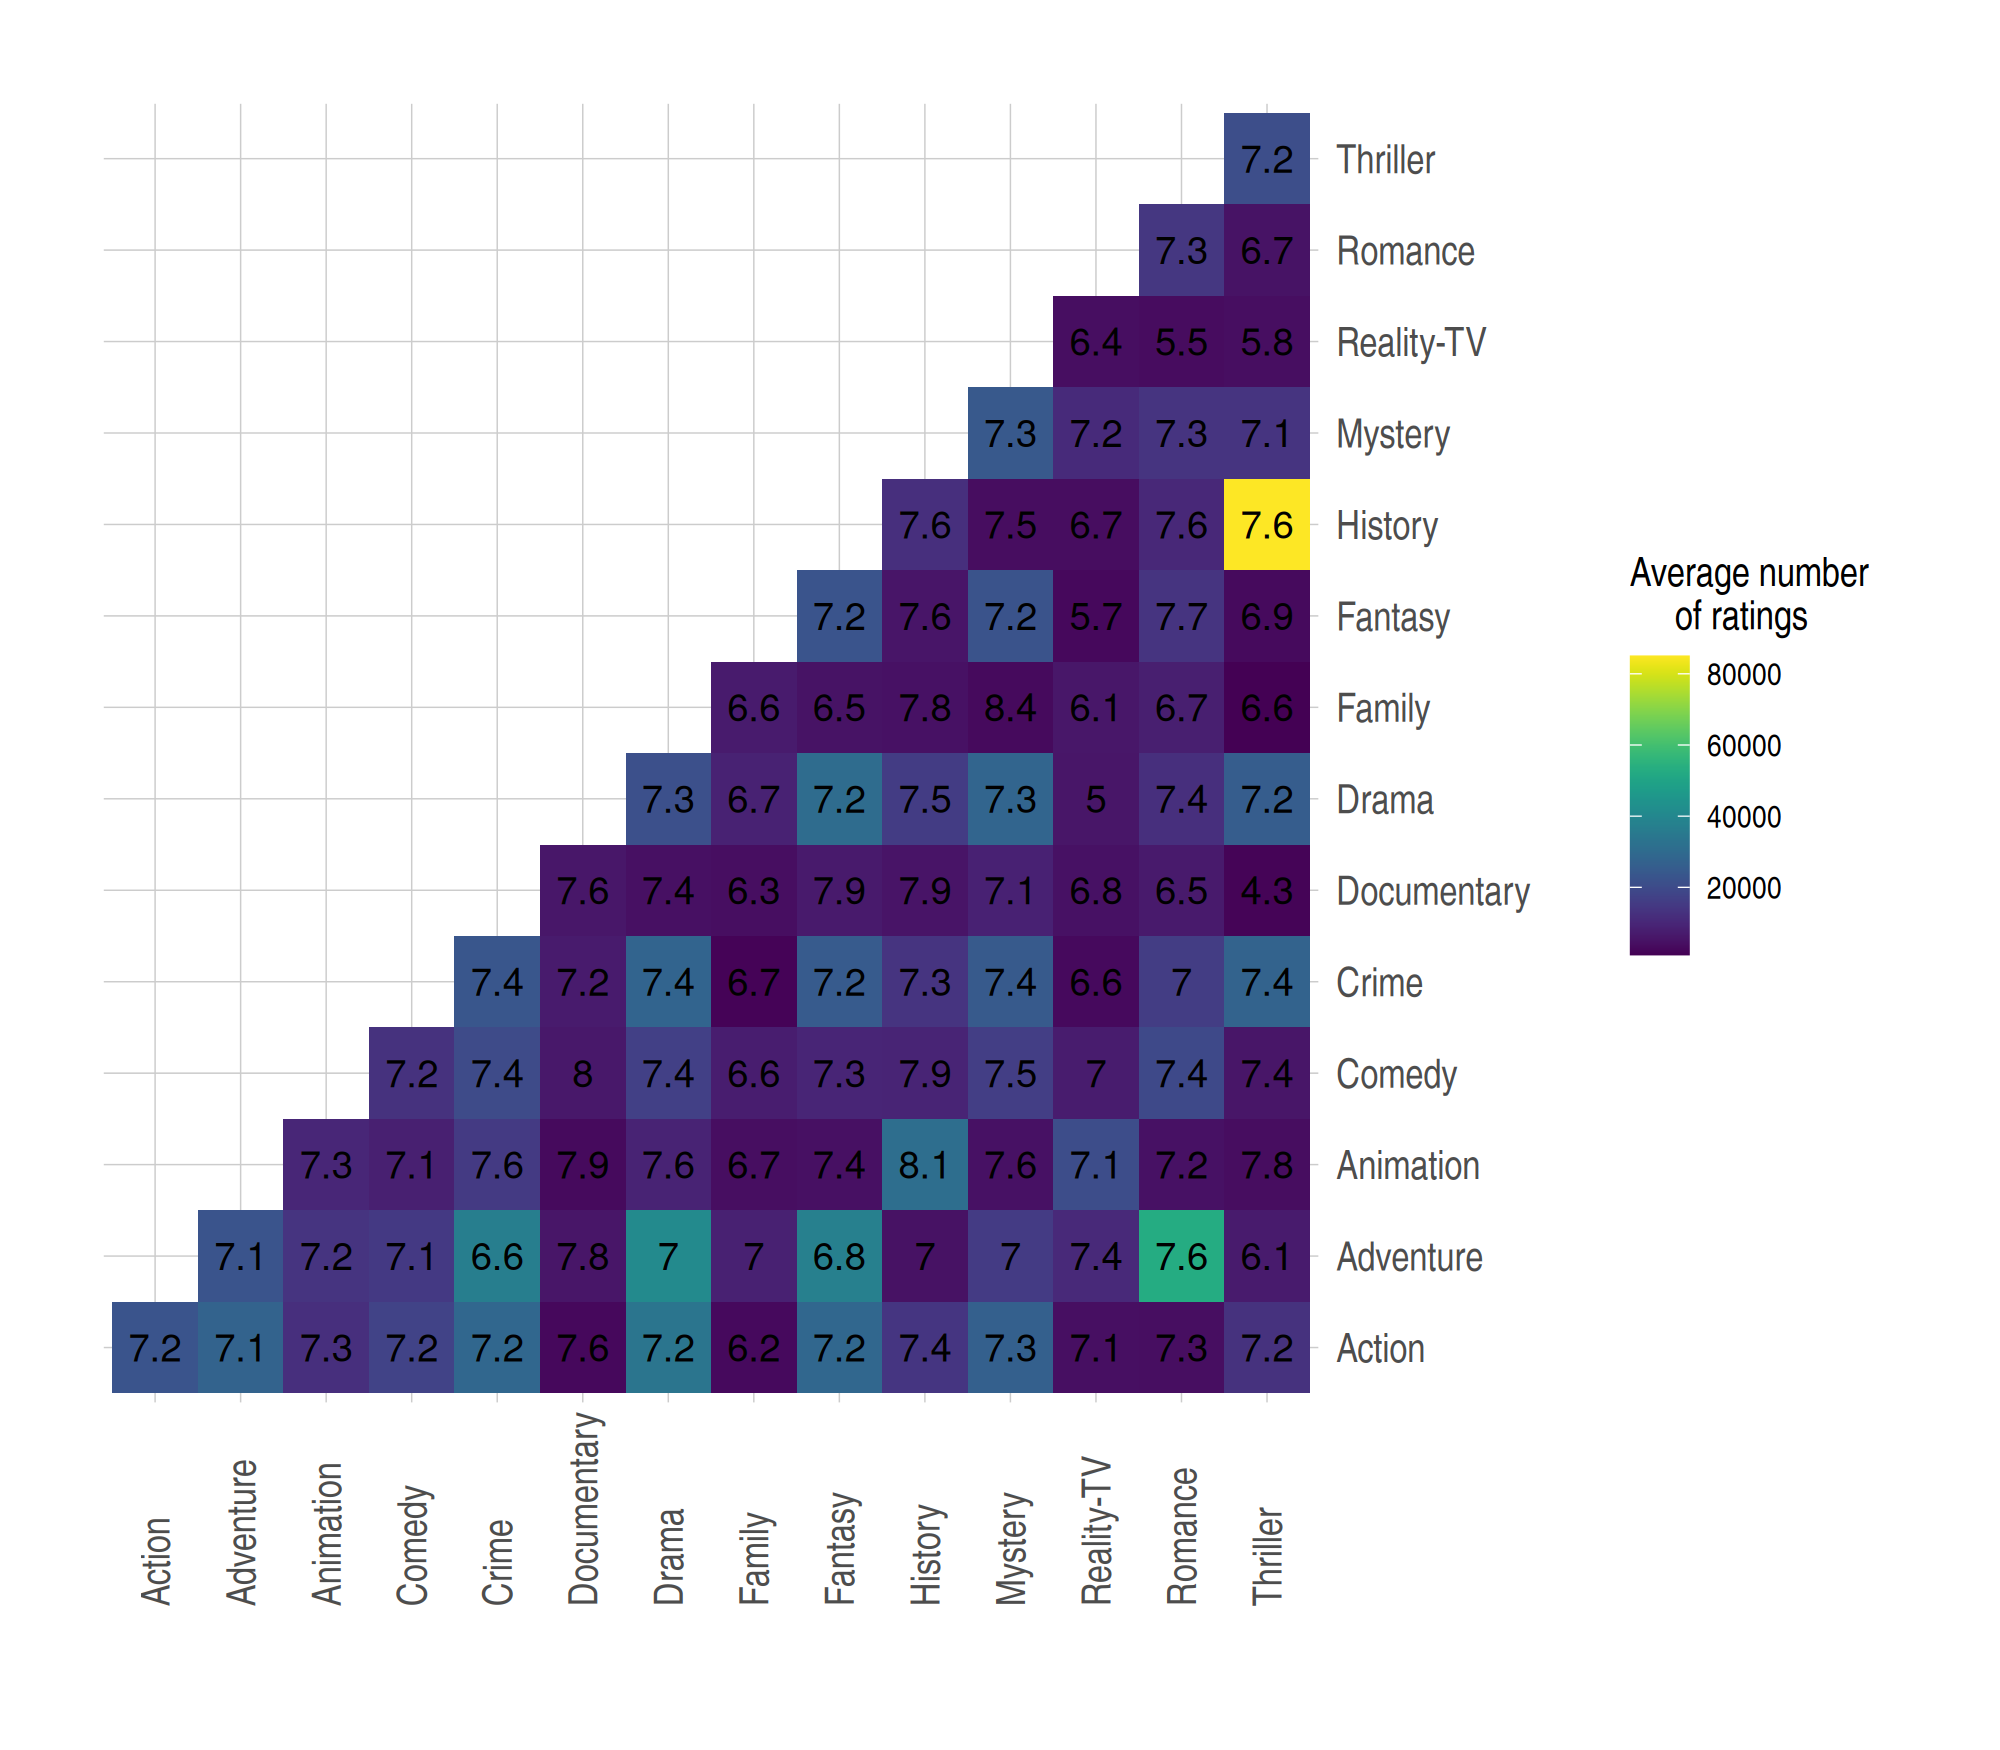

In [96]:
ggplot(heat_df, aes(x = y, y = x, fill=reviews_avg)) + 
  geom_tile() +
  scale_y_discrete(position = "right") +
  scale_fill_viridis(discrete=FALSE) +
  theme_ipsum() +
  geom_text(aes(label = round(rating_avg, 1))) +
  labs(fill = "Average number \n     of ratings") +
  xlab("") + 
  ylab("") +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=0))

**Categories together average num of seaons and number of tv series comprising of the given two categories**

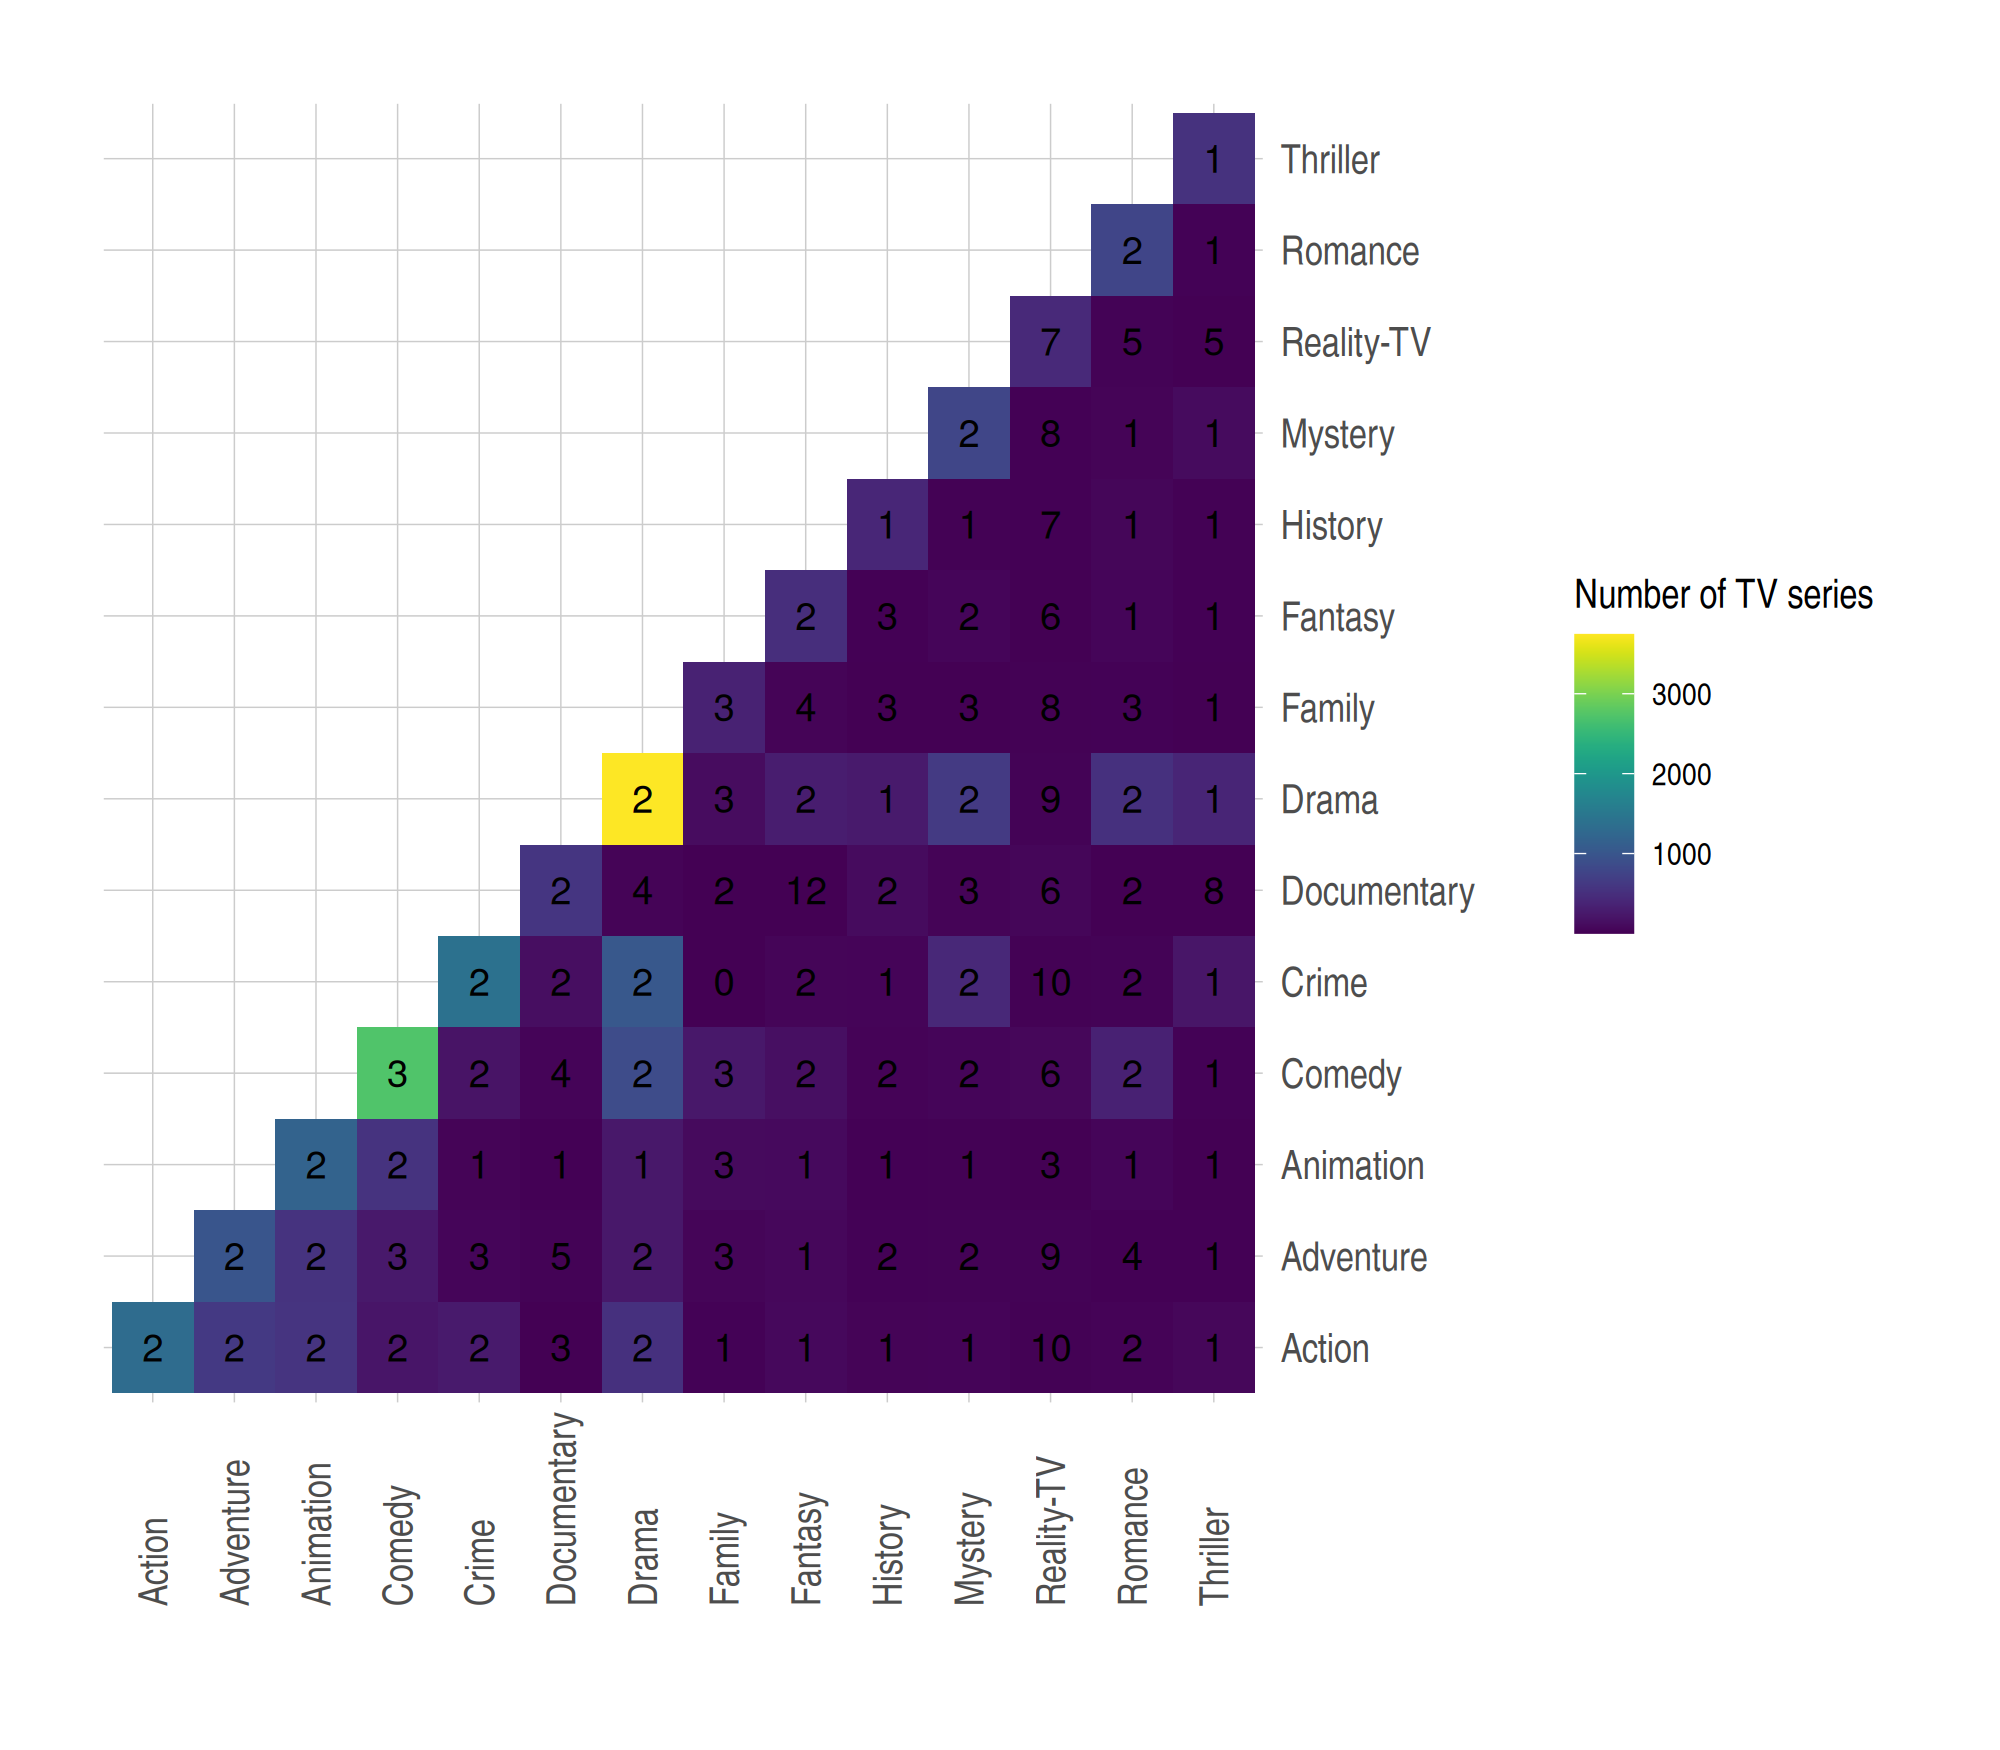

In [97]:
ggplot(heat_df, aes(x = y, y = x, fill=amount)) + 
  geom_tile() +
  scale_y_discrete(position = "right") +
  scale_fill_viridis(discrete=FALSE) +
  theme_ipsum() +
  geom_text(aes(label = round(seasons, 1))) +
  labs(fill = "Number of TV series") +
  xlab("") + 
  ylab("") +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=0))